In [225]:
import pandas as pd 
import numpy as np
from app import get_altum_age, get_hannum_age, get_Han2020_age, get_horvath_age, get_horvath_sb_age, get_pheno_age, get_YingCaus_age, get_ZhangEn_age
import re
import pandas as pd
from clocks import han2020_coefs


zhangen_params = pd.read_table('clocks/zhangen.coef', sep=' ')
zhangen_params['feature'] = zhangen_params['probe']
zhangen_params['coefficient'] = zhangen_params['coef']
zhangen_cpgs = zhangen_params['feature'][1:].tolist()

yingCausAge_params = pd.read_csv('clocks/YingCausAge.csv')
yingCausAge_params['feature'] = yingCausAge_params['term']
yingCausAge_params['coefficient'] = yingCausAge_params['estimate']
yingCausAge_cpgs = yingCausAge_params['feature'][1:].tolist()

han2020_cpgs = han2020_coefs.cpgs
cpgs = pd.read_csv("tools/union_out.csv")
cpgs_list = list(set(cpgs.iloc[:, 0].tolist() + yingCausAge_cpgs + zhangen_cpgs + han2020_coefs.cpgs))
#cpgs_list.extend(['cg13326338', 'cg24497877'])

print(len(cpgs_list))


22616


In [226]:
import re
import pandas as pd

# Read the file
file_path = '/Users/yashagarwal/Downloads/GSE195834_series_matrix.txt'

# Read the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Initialize lists for columns
samples = []
tissues = []
ages = []

# Regular expressions to match patterns
age_pattern = re.compile(r'age:\s*(\d+)')

# Parsing logic to fill in samples, tissues, and ages
for line in lines:
    if line.startswith('!Sample_title'):
        titles = line.split('\t')
        for title in titles[1:]:  # Skip the first entry since it's the header
            sample, tissue = re.match(r'"?(.+?)\s+\[(.+)\]"?', title.strip()).groups()
            samples.append(sample)
            tissues.append(tissue)
        # Initialize the ages list with the same length as samples
        ages = [''] * len(samples)
    if line.startswith('!Sample_characteristics_ch1'):
        characteristics = line.split('\t')
        for i, characteristic in enumerate(characteristics[1:], 1):  # Skip the first entry since it's the header
            age_match = age_pattern.search(characteristic)
            if age_match:
                ages[i-1] = age_match.group(1).strip()  # Adjust index since sample IDs start from 0

# Combine the columns into a structured format
organized_data = list(zip(samples, tissues, ages))

df = pd.DataFrame(organized_data, columns=['Sample', 'Tissue', 'Age'])

df_anno = df

print(df_anno)



          Sample   Tissue Age
0   Sample_14901  Control  71
1   Sample_14902  Control  75
2   Sample_14903  Control  76
3   Sample_14904  Control  77
4   Sample_14905  Control  79
..           ...      ...  ..
73  Sample_14979  Control  59
74  Sample_14980  Control  79
75  Sample_14981  Control  73
76  Sample_14982  Control  74
77  Sample_14983  Control  83

[78 rows x 3 columns]


In [247]:
df = pd.read_csv("/Users/yashagarwal/Downloads/GSE195834_2-PD-processed.csv")
columns_to_remove = df.columns[2::2]
df_dropped = df.drop(columns=columns_to_remove)
df = df_dropped
print(df)


            ID_REF  Sample_14901  Sample_14902  Sample_14903  Sample_14904  \
0       cg18478105      0.012928      0.011693      0.009873      0.011774   
1       cg09835024      0.029747      0.036241      0.034418      0.026570   
2       cg14361672      0.928005      0.936565      0.958633      0.959924   
3       cg01763666      0.957944      0.957048      0.959468      0.943942   
4       cg12950382      0.892283      0.836956      0.839780      0.910867   
...            ...           ...           ...           ...           ...   
866086  cg23079522      0.752038      0.758175      0.701990      0.729688   
866087  cg16818145      0.864927      0.790178      0.858218      0.817019   
866088  cg14585103      0.860005      0.833862      0.842647      0.844067   
866089  cg10633746      0.067285      0.081805      0.056887      0.049490   
866090  cg12623625      0.667312      0.681425      0.676948      0.727561   

        Sample_14905  Sample_14906  Sample_14907  Sample_14908 

In [248]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

filtered_df = df[df.iloc[:, 0].isin(cpgs_list)]
df = filtered_df
print(df)

            ID_REF  Sample_14901  Sample_14902  Sample_14903  Sample_14904  \
22      cg11890956      0.013205      0.011089      0.021380      0.015455   
84      cg00347904      0.049217      0.079336      0.056682      0.075081   
180     cg26196700      0.014816      0.012183      0.022950      0.017505   
192     cg19591206      0.013133      0.013856      0.013944      0.007203   
274     cg15482690      0.014105      0.013752      0.012199      0.014936   
...            ...           ...           ...           ...           ...   
865806  cg08493463      0.351890      0.368071      0.429335      0.391693   
865908  cg09155905      0.066059      0.058072      0.066218      0.050214   
865938  cg14709524      0.061259      0.074522      0.070983      0.064657   
865955  cg27419217      0.043825      0.065044      0.075746      0.047098   
865989  cg17163751      0.056285      0.057452      0.027097      0.035873   

        Sample_14905  Sample_14906  Sample_14907  Sample_14908 

In [249]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
pd.options.mode.copy_on_write = True

missing_values = [cpg_id for cpg_id in cpgs_list if cpg_id not in df.iloc[:, 0].values]
print(len(missing_values))


new_rows = []

for value in missing_values:
    #print(count)
    new_row = pd.DataFrame([[value] + [np.nan] * (df.shape[1] - 1)], columns=df.columns)  # Create a new row DataFrame
    #print(new_row)
    new_rows.append(new_row)
    
    #df.loc[len(df)] = new_row  # Add new row to DataFrame
    
df = pd.concat([df] + new_rows, ignore_index=True)



labels = df.iloc[:, 0]  # Assuming the first column contains the CPG labels
#print(labels)
methylation_data = df.iloc[:, 1:]  # Assuming the methylation data starts from the second column
#print("1")
#print(methylation_data)
#print("2")
df.fillna(np.nan, inplace=True)

# Impute missing values using IterativeImputer
imputer_iterative = IterativeImputer(max_iter=10, random_state=0)  # You can adjust max_iter as needed
imputed_data_iterative = imputer_iterative.fit_transform(methylation_data)

# Convert imputed data back to DataFrame
# Create the DataFrame
imputed_df_iterative = pd.DataFrame(imputed_data_iterative, columns=methylation_data.columns)

labels = df.iloc[:, 0].tolist()
# Create a new DataFrame to store the results
imputed_df_iterative_with_labels = pd.DataFrame(columns=['Labels'] + imputed_df_iterative.columns.tolist())

# Iterate through the labels and add them to the new DataFrame
for i in range(len(labels)):
    # Create a new row with the label as the first value and the corresponding row from imputed_df_iterative
    new_row = [labels[i]] + imputed_df_iterative.iloc[i].tolist()
    # Append the new row to the DataFrame
    imputed_df_iterative_with_labels.loc[i] = new_row

# Display the updated DataFrame
print(imputed_df_iterative_with_labels)

'''# Debugging: Check the shapes and lengths
print("Shape of imputed_df_iterative:", imputed_df_iterative.shape)
print("Length of labels:", len(labels))

# Check for NaN values in labels
print("NaN values in labels:", labels.isna().sum())

# Check for NaN values in imputed_df_iterative
print("NaN values in imputed_df_iterative:")
print(imputed_df_iterative.isna().sum().sum())
# Concatenate labels with the imputed_df_iterative
labels_df = pd.DataFrame(labels)
final_df = pd.concat([labels_df, imputed_df_iterative], axis=1)

# Debugging: Check the final DataFrame
print(final_df)
print("Shape of final DataFrame:", final_df.shape)

# Update df to be the final DataFrame
df = final_df'''

197
           Labels  Sample_14901  Sample_14902  Sample_14903  Sample_14904  \
0      cg11890956      0.013205      0.011089      0.021380      0.015455   
1      cg00347904      0.049217      0.079336      0.056682      0.075081   
2      cg26196700      0.014816      0.012183      0.022950      0.017505   
3      cg19591206      0.013133      0.013856      0.013944      0.007203   
4      cg15482690      0.014105      0.013752      0.012199      0.014936   
...           ...           ...           ...           ...           ...   
22611  cg25339052      0.298123      0.298210      0.298235      0.296323   
22612  cg24471894      0.298123      0.298210      0.298235      0.296323   
22613  cg07155684      0.298123      0.298210      0.298235      0.296323   
22614  cg03844971      0.298123      0.298210      0.298235      0.296323   
22615  cg24760922      0.298123      0.298210      0.298235      0.296323   

       Sample_14905  Sample_14906  Sample_14907  Sample_14908  Sample_1

'# Debugging: Check the shapes and lengths\nprint("Shape of imputed_df_iterative:", imputed_df_iterative.shape)\nprint("Length of labels:", len(labels))\n\n# Check for NaN values in labels\nprint("NaN values in labels:", labels.isna().sum())\n\n# Check for NaN values in imputed_df_iterative\nprint("NaN values in imputed_df_iterative:")\nprint(imputed_df_iterative.isna().sum().sum())\n# Concatenate labels with the imputed_df_iterative\nlabels_df = pd.DataFrame(labels)\nfinal_df = pd.concat([labels_df, imputed_df_iterative], axis=1)\n\n# Debugging: Check the final DataFrame\nprint(final_df)\nprint("Shape of final DataFrame:", final_df.shape)\n\n# Update df to be the final DataFrame\ndf = final_df'

In [250]:
df = imputed_df_iterative_with_labels
print(df)
print(df.columns)


           Labels  Sample_14901  Sample_14902  Sample_14903  Sample_14904  \
0      cg11890956      0.013205      0.011089      0.021380      0.015455   
1      cg00347904      0.049217      0.079336      0.056682      0.075081   
2      cg26196700      0.014816      0.012183      0.022950      0.017505   
3      cg19591206      0.013133      0.013856      0.013944      0.007203   
4      cg15482690      0.014105      0.013752      0.012199      0.014936   
...           ...           ...           ...           ...           ...   
22611  cg25339052      0.298123      0.298210      0.298235      0.296323   
22612  cg24471894      0.298123      0.298210      0.298235      0.296323   
22613  cg07155684      0.298123      0.298210      0.298235      0.296323   
22614  cg03844971      0.298123      0.298210      0.298235      0.296323   
22615  cg24760922      0.298123      0.298210      0.298235      0.296323   

       Sample_14905  Sample_14906  Sample_14907  Sample_14908  Sample_14909

In [224]:
print(df)

           CPG ID  Sample_14901  Sample_14902  Sample_14903  Sample_14904  \
0             NaN      0.013205      0.011089      0.021380      0.015455   
1             NaN      0.049217      0.079336      0.056682      0.075081   
2             NaN      0.014816      0.012183      0.022950      0.017505   
3             NaN      0.013133      0.013856      0.013944      0.007203   
4             NaN      0.014105      0.013752      0.012199      0.014936   
...           ...           ...           ...           ...           ...   
22507  cg09651136      0.298134      0.298222      0.298247      0.296335   
22508  cg12042659      0.298134      0.298222      0.298247      0.296335   
22509  cg17681698      0.298134      0.298222      0.298247      0.296335   
22510  cg24977886      0.298134      0.298222      0.298247      0.296335   
22511  cg08415508      0.298134      0.298222      0.298247      0.296335   

       Sample_14905  Sample_14906  Sample_14907  Sample_14908  Sample_14909

In [309]:

# Get the indices of rows where 'Group' is 'control' and 'pd'
control_indices = df_anno.index[df_anno.iloc[:, 1] == 'Control'].tolist()
pd_indices = df_anno.index[df_anno.iloc[:, 1] == 'PD'].tolist()
#print(control_indices)
# Rearrange indices such that 'control' values are first followed by 'pd'
sorted_indices = control_indices + pd_indices

#print(sorted_indices)
# Reindex the DataFrame based on the sorted indices
df_anno_sorted = df_anno.iloc[sorted_indices]
df_anno_sorted.reset_index(drop=True, inplace=True)


df_anno_sorted = pd.DataFrame(df_anno_sorted)
print(df_anno_sorted)    

          Sample   Tissue Age
0   Sample_14901  Control  71
1   Sample_14902  Control  75
2   Sample_14903  Control  76
3   Sample_14904  Control  77
4   Sample_14905  Control  79
..           ...      ...  ..
73  Sample_14967       PD  77
74  Sample_14969       PD  80
75  Sample_14970       PD  87
76  Sample_14975       PD  81
77  Sample_14976       PD  74

[78 rows x 3 columns]


In [320]:
altum_pred = np.expand_dims(np.float32(get_altum_age(df)), axis=0)
hannum_pred = np.expand_dims(np.float32(get_hannum_age(df)), axis=0)
horvath_pred = np.expand_dims(np.float32(get_horvath_age(df)), axis=0)
pheno_pred = np.expand_dims(np.float32(get_pheno_age(df)), axis=0)
horvath_sb_pred = np.expand_dims(np.float32(get_horvath_sb_age(df)), axis=0)
pred_zhangEn = np.expand_dims(np.float32(get_ZhangEn_age(df)), axis=0)
pred_han2020 = np.expand_dims(np.float32(get_Han2020_age(df)), axis=0)
pred_yingCaus = np.expand_dims(np.float32(get_YingCaus_age(df)), axis=0)

# Coefficients and intercept
coefficients = np.array([0.3437195049507392, -0.20633851531241806, -0.5173259165634722, 
                         0.2836010547077375, 0.1857810346592119, -0.02208310995460718, 
                         -0.08526975203798473, 0.5640149630320757])
intercept = 19.275324793823557

# Reshape predictions to (404, 1) for broadcasting
altum_pred = altum_pred.reshape(-1, 1)
pred_han2020 = pred_han2020.reshape(-1, 1)
hannum_pred = hannum_pred.reshape(-1, 1)
horvath_pred = horvath_pred.reshape(-1, 1)
horvath_sb_pred = horvath_sb_pred.reshape(-1, 1)
pheno_pred = pheno_pred.reshape(-1, 1)
pred_yingCaus = pred_yingCaus.reshape(-1, 1)
pred_zhangEn = pred_zhangEn.reshape(-1, 1)

# Calculating the ensemble prediction
ensembleLR_pred = np.round(intercept +
                           (coefficients[0] * altum_pred) +
                           (coefficients[1] * pred_han2020) +
                           (coefficients[2] * hannum_pred) +
                           (coefficients[3] * horvath_pred) +
                           (coefficients[4] * horvath_sb_pred) +
                           (coefficients[5] * pheno_pred) +
                           (coefficients[6] * pred_yingCaus) +
                           (coefficients[7] * pred_zhangEn), 2)




ensembleLR_pred = ensembleLR_pred.flatten()  # Flatten if necessary
ensembleLR_pred_sorted = [ensembleLR_pred[i] for i in sorted_indices]
#print(ensembleLR_pred_sorted)
#print(*ensembleLR_pred_sorted, sep='\n')




real_ages = df_anno_sorted.iloc[:, 2]
real_ages = real_ages.values.tolist()

real_ages = [float(age.strip("'")) for age in real_ages]

print(real_ages)
#print(real_ages, sep = '\n')
#for value in real_ages:
    #print(value)


ensemble_naive_pred = np.concatenate(np.mean([altum_pred, hannum_pred, horvath_pred, pheno_pred, horvath_sb_pred, pred_zhangEn, pred_han2020, pred_yingCaus],axis=0), ).T
ensemble_naive_pred_sorted = [ensemble_naive_pred[i] for i in sorted_indices]

#print(*ensemble_naive_pred_sorted, sep='\n')

#print(ensemble_naive_pred)

    
#tissue = df_anno_sorted.iloc[:, 2]
# value in tissue:
    #print(value)
    
    


/Users/yashagarwal/anaconda3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


3/3 [==============================] - 0s 3ms/step
[71.0, 75.0, 76.0, 77.0, 79.0, 82.0, 83.0, 84.0, 86.0, 87.0, 71.0, 86.0, 80.0, 82.0, 76.0, 72.0, 73.0, 74.0, 83.0, 79.0, 83.0, 77.0, 85.0, 84.0, 74.0, 79.0, 69.0, 78.0, 70.0, 72.0, 77.0, 86.0, 74.0, 59.0, 79.0, 73.0, 74.0, 83.0, 78.0, 73.0, 71.0, 71.0, 70.0, 85.0, 79.0, 80.0, 72.0, 76.0, 83.0, 72.0, 73.0, 74.0, 82.0, 79.0, 70.0, 79.0, 71.0, 74.0, 83.0, 87.0, 84.0, 78.0, 72.0, 70.0, 77.0, 87.0, 83.0, 84.0, 79.0, 84.0, 83.0, 73.0, 81.0, 77.0, 80.0, 87.0, 81.0, 74.0]


/Users/yashagarwal/Documents/GitHub/EnsembleMeAgingClock/app.py:170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = np.matmul (input2, coef) + df_slope_only['CoefficientTraining'][0]


In [401]:

real_ages
ensembleLR_pred_sorted
ensemble_naive_pred_sorted

real_ages_control = real_ages[:38]
real_ages_pd = real_ages[38:]

ensembleLR_pred_sorted_control = ensembleLR_pred_sorted[:38]
ensembleLR_pred_sorted_pd = ensembleLR_pred_sorted[38:]

ensemble_naive_pred_sorted_control = ensemble_naive_pred_sorted[:38]
ensemble_naive_pred_sorted_pd = ensemble_naive_pred_sorted[38:]




In [356]:
from scipy import stats

# Perform the two-sample KS test
ks_statistic, p_value = stats.ks_2samp(real_ages_control, real_ages_pd)

# Print the KS statistic and p-value
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")


KS Statistic: 0.06315789473684211
P-value: 0.9999538081992599


In [402]:
print(ensembleLR_pred_sorted_control)

[75.9, 84.86, 82.23, 79.88, 83.07, 85.12, 82.14, 82.81, 83.24, 87.22, 79.03, 84.25, 83.04, 89.16, 88.06, 83.48, 76.48, 83.56, 82.24, 81.71, 84.55, 83.83, 81.11, 86.41, 82.46, 82.43, 75.93, 79.1, 80.37, 76.75, 78.89, 84.14, 82.04, 68.08, 87.69, 83.11, 81.22, 83.15]


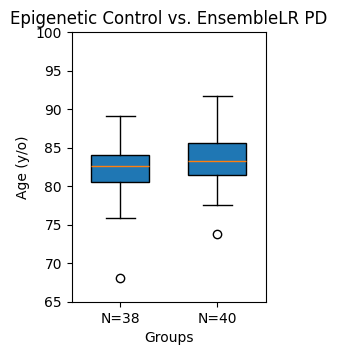

In [446]:
import matplotlib.pyplot as plt

# Combine the data into a list
data = [ensembleLR_pred_sorted_control, ensembleLR_pred_sorted_pd]

# Create a box plot with reduced width but larger boxplots
plt.figure(figsize=(2.5, 3.5))  # Keep the figure size small
plt.boxplot(data, vert=True, patch_artist=True, labels=['N=38', 'N=40'], widths=0.6)  # Increase the width of the boxplots

# Add title and labels
plt.title('Epigenetic Control vs. EnsembleLR PD')
plt.xlabel('Groups')
plt.ylabel('Age (y/o)')

# Set y-axis limits
plt.ylim(65, 100)

# Show the plot
plt.show()


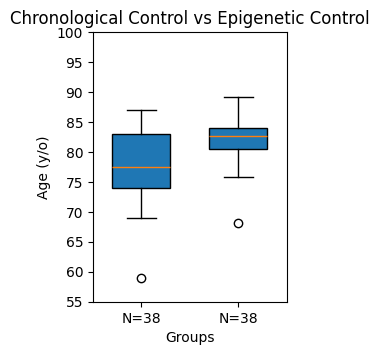

In [448]:
import matplotlib.pyplot as plt

# Combine the data into a list
data = [real_ages_control, ensembleLR_pred_sorted_control]

# Create a box plot with increased width
plt.figure(figsize=(2.5, 3.5))
plt.boxplot(data, vert=True, patch_artist=True, labels=['N=38', 'N=38'], widths=0.6)  # Increase the width of the boxplots

# Add title and labels
plt.title('Chronological Control vs Epigenetic Control')
plt.xlabel('Groups')
plt.ylabel('Age (y/o)')

# Set y-axis limits
plt.ylim(55, 100)

# Show the plot
plt.show()


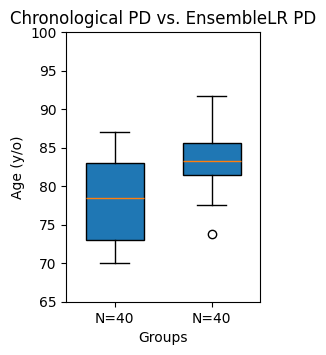

In [444]:
import matplotlib.pyplot as plt

# Combine the data into a list
data = [real_ages_pd, ensembleLR_pred_sorted_pd]

# Create a box plot with increased width
plt.figure(figsize=(2.5, 3.5))
plt.boxplot(data, vert=True, patch_artist=True, labels=['N=40', 'N=40'], widths=0.6)  # Increase the width of the boxplots

# Add title and labels
plt.title('Chronological PD vs. EnsembleLR PD')
plt.xlabel('Groups')
plt.ylabel('Age (y/o)')

# Set y-axis limits
plt.ylim(65, 100)

# Show the plot
plt.show()
